## Loading Dataset

In [1]:
import pandas as pd 
import numpy as np 

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../data/raw/occurrence.txt', sep='\t')
display(df.head(3))
df.shape

C:\Users\SABIO\AppData\Local\Temp\ipykernel_36260\3377765415.py:1: DtypeWarning: Columns (29,30,35,43,46,49,53,60,75,77,83,102,103,112,113,114,115,116,117,118,132,133,137,138,147,170,177) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/occurrence.txt', sep='\t')


,gbifID,accessRights,bibliographicCitation,language,license,modified,publisher,references,rightsHolder,type,institutionID,collectionID,datasetID,institutionCode,collectionCode,datasetName,ownerInstitutionCode,basisOfRecord,informationWithheld,dataGeneralizations,dynamicProperties,occurrenceID,catalogNumber,recordNumber,recordedBy,recordedByID,individualCount,organismQuantity,organismQuantityType,sex,lifeStage,reproductiveCondition,caste,behavior,vitality,establishmentMeans,degreeOfEstablishment,pathway,georeferenceVerificationStatus,occurrenceStatus,preparations,disposition,associatedOccurrences,associatedReferences,associatedSequences,associatedTaxa,otherCatalogNumbers,occurrenceRemarks,organismID,organismName,organismScope,associatedOrganisms,previousIdentifications,organismRemarks,materialEntityID,materialEntityRemarks,verbatimLabel,materialSampleID,eventID,parentEventID,eventType,fieldNumber,eventDate,eventTime,startDayOfYear,endDayOfYear,year,month,day,verbatimEventDate,habitat,samplingProtocol,sampleSizeValue,sampleSizeUnit,samplingEffort,fieldNotes,eventRemarks,locationID,higherGeographyID,higherGeography,continent,waterBody,islandGroup,island,countryCode,stateProvince,county,municipality,locality,verbatimLocality,verbatimElevation,verticalDatum,verbatimDepth,minimumDistanceAboveSurfaceInMeters,maximumDistanceAboveSurfaceInMeters,locationAccordingTo,locationRemarks,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,pointRadiusSpatialFit,verbatimCoordinateSystem,verbatimSRS,footprintWKT,footprintSRS,footprintSpatialFit,georeferencedBy,georeferencedDate,georeferenceProtocol,georeferenceSources,georeferenceRemarks,geologicalContextID,earliestEonOrLowestEonothem,latestEonOrHighestEonothem,earliestEraOrLowestErathem,latestEraOrHighestErathem,earliestPeriodOrLowestSystem,latestPeriodOrHighestSystem,earliestEpochOrLowestSeries,latestEpochOrHighestSeries,earliestAgeOrLowestStage,latestAgeOrHighestStage,lowestBiostratigraphicZone,highestBiostratigraphicZone,lithostratigraphicTerms,group,formation,member,bed,identificationID,verbatimIdentification,identificationQualifier,typeStatus,identifiedBy,identifiedByID,dateIdentified,identificationReferences,identificationVerificationStatus,identificationRemarks,taxonID,scientificNameID,acceptedNameUsageID,parentNameUsageID,originalNameUsageID,nameAccordingToID,namePublishedInID,taxonConceptID,scientificName,acceptedNameUsage,parentNameUsage,originalNameUsage,nameAccordingTo,namePublishedIn,namePublishedInYear,higherClassification,kingdom,phylum,class,order,superfamily,family,subfamily,tribe,subtribe,genus,genericName,subgenus,infragenericEpithet,specificEpithet,infraspecificEpithet,cultivarEpithet,taxonRank,verbatimTaxonRank,vernacularName,nomenclaturalCode,taxonomicStatus,nomenclaturalStatus,taxonRemarks,datasetKey,publishingCountry,lastInterpreted,elevation,elevationAccuracy,depth,depthAccuracy,distanceFromCentroidInMeters,issue,mediaType,hasCoordinate,hasGeospatialIssues,taxonKey,acceptedTaxonKey,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,subgenusKey,speciesKey,species,acceptedScientificName,verbatimScientificName,typifiedName,protocol,lastParsed,lastCrawled,repatriated,relativeOrganismQuantity,projectId,isSequenced,gbifRegion,publishedByGbifRegion,level0Gid,level0Name,level1Gid,level1Name,level2Gid,level2Name,level3Gid,level3Name,iucnRedListCategory
0,931073241,NaN,NaN,en,CC0_1_0,NaN,NaN,NaN,University of Guelph,NaN,NaN,NaN,http://dataset.canadensys.net/oac-specimens,Biodiversity Institute of Ontario,OAC,Ontario Agriculture College Herbarium (OAC-BIO),NaN,PRESERVED_SPECIMEN,NaN,NaN,NaN,41403,53588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PRESENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

(7240, 223)

## Extracting Meaninful Variables

Found some occurrances appearing in ASIA and CANADA. These should be removed.

In [3]:
display(df['continent'].value_counts())
display(df[df['verbatimLocality'].str.startswith('Canada', na=False)]['verbatimLocality'].value_counts())

continent
NORTH_AMERICA    6287
ASIA               15
Name: count, dtype: int64

After ASIA and CANADA have been removed, we select all variables related to location and time in order to further clean the dataset and geocode any locations with fragmented data.

In [6]:
# Create list of columns from the comment
columns_to_keep = ['gbifID','reproductiveCondition', 'occurrenceStatus', 
                  'eventDate', 'eventTime', 'startDayOfYear', 'endDayOfYear', 'year',
                  'month', 'day', 'verbatimEventDate', 'habitat', 'higherGeography',
                  'continent', 'countryCode', 'stateProvince', 'county', 'municipality',
                  'locality', 'verbatimLocality', 'verbatimElevation',
                  'minimumDistanceAboveSurfaceInMeters', 'maximumDistanceAboveSurfaceInMeters',
                  'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters',
                  'georeferencedDate', 'dateIdentified', 'elevation', 'elevationAccuracy',
                  'hasCoordinate', 'hasGeospatialIssues']

# Drop rows where continent is ASIA
df = df[
    (df['continent'] != 'ASIA') & 
    (~df['verbatimLocality'].str.startswith('Canada', na=False))
]

# Create a copy with only the specified columns
df_detailed = df[columns_to_keep].copy()

# Split columns into coordinate and location groups
coordinate_columns = ['decimalLatitude', 'decimalLongitude']
location_columns = ['countryCode', 'stateProvince', 'county', 'municipality', 'locality']

# Keep rows that have either:
# 1. Both coordinates (lat & long)
# 2. At least one location field filled
has_coordinates = df_detailed[coordinate_columns].notna().all(axis=1)
has_location = df_detailed[location_columns].notna().any(axis=1)

# Apply the filter to keep rows with either coordinates or location info
df_pruned = df_detailed[has_coordinates | has_location].copy()

print(f"\nOriginal shape: {df_detailed.shape}")
print(f"Shape after filtering: {df_pruned.shape}")
print(f"Removed {df_detailed.shape[0] - df_pruned.shape[0]} rows")

# Save pruned dataset
#df_pruned.to_csv('../data/processed/pruned.csv', index=False)

# Display first few rows to verify the data
print("\nPruned dataset preview:")
# Display removed rows
removed_rows = df_detailed[~(has_coordinates | has_location)]
print("\nRemoved rows preview:")
display(removed_rows.head())

print("\nPruned dataset preview:")
display(df_pruned.head())


Original shape: (7046, 32)
Shape after filtering: (6823, 32)
Removed 223 rows

Pruned dataset preview:

Removed rows preview:


,gbifID,reproductiveCondition,occurrenceStatus,eventDate,eventTime,startDayOfYear,endDayOfYear,year,month,day,verbatimEventDate,habitat,higherGeography,continent,countryCode,stateProvince,county,municipality,locality,verbatimLocality,verbatimElevation,minimumDistanceAboveSurfaceInMeters,maximumDistanceAboveSurfaceInMeters,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,georeferencedDate,dateIdentified,elevation,elevationAccuracy,hasCoordinate,hasGeospatialIssues
0,931073241,NaN,PRESENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,931040138,NaN,PRESENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
19,695167951,NaN,PRESENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
20,695167945,NaN,PRESENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
21,694280617,NaN,PRESENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False



Pruned dataset preview:


,gbifID,reproductiveCondition,occurrenceStatus,eventDate,eventTime,startDayOfYear,endDayOfYear,year,month,day,verbatimEventDate,habitat,higherGeography,continent,countryCode,stateProvince,county,municipality,locality,verbatimLocality,verbatimElevation,minimumDistanceAboveSurfaceInMeters,maximumDistanceAboveSurfaceInMeters,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,georeferencedDate,dateIdentified,elevation,elevationAccuracy,hasCoordinate,hasGeospatialIssues
2,894988018,NaN,PRESENT,1970-07-11,NaN,192.0,192.0,1970.0,7.0,11.0,NaN,"scree slope, facing east",NaN,NORTH_AMERICA,CA,Alberta,NaN,Waterton Lakes National Park,West of Lost Lake,NaN,7000 feet,NaN,NaN,49.133333,-114.15,NaN,NaN,NaN,2133.0,0.0,True,False
3,894988016,NaN,PRESENT,1968-08-04,NaN,217.0,217.0,1968.0,8.0,4.0,NaN,Trail side,NaN,NORTH_AMERICA,CA,Alberta,NaN,Waterton Lakes National Park,"near campsite, north-west of Cameron Lake",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
4,894987984,NaN,PRESENT,1970-07-11,NaN,192.0,192.0,1970.0,7.0,11.0,NaN,"scree slope, facing east",NaN,NORTH_AMERICA,CA,Alberta,NaN,Waterton Lakes National Park,West of Lost Lake,NaN,7000 feet,NaN,NaN,49.133333,-114.15,NaN,NaN,NaN,2133.0,0.0,True,False
5,894987983,NaN,PRESENT,1959-07-10,NaN,191.0,191.0,1959.0,7.0,10.0,NaN,Coniferous forest,NaN,NORTH_AMERICA,US,Wyoming,NaN,NaN,Teton Pass,NaN,8400 feet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2560.0,0.0,False,False
6,894987960,NaN,PRESENT,1970-07-11,NaN,192.0,192.0,1970.0,7.0,11.0,NaN,"scree slope, facing east",NaN,NORTH_AMERICA,CA,Alberta,NaN,Waterton Lakes National Park,West of Lost Lake,NaN,7000 feet,NaN,NaN,49.133333,-114.15,NaN,NaN,NaN,2133.0,0.0,True,False


## Geocoding (Lon & Lat Cleaning)

858 rows that do not have longitude or latitude however might have relevant data for geocoding including their locality.

In [7]:
df_pruned[df_pruned['decimalLatitude'].isna() & df_pruned['decimalLongitude'].isna()].shape

(858, 32)

In [ ]:
import sys
sys.path.append('..')
from src.geocoding import process_dataset
import pandas as pd
import os

# Load your original dataset (assuming it's df_pruned or similar)
# Replace 'df_pruned' with whatever your original dataframe variable name is
df_original = df_pruned.copy()  # or whatever your original dataframe is called

# Process ALL rows that don't have coordinates with the updated logic
df_enhanced, stats = process_dataset(df_original)

# Save the updated dataframe
output_path = '../data/processed/updated_coordinates_with_verbatim.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_enhanced.to_csv(output_path, index=False)
print(f"\nSaved updated coordinates to: {output_path}")

# Show remaining rows without coordinates
print("\nRemaining rows without coordinates:")
display(df_enhanced[df_enhanced['decimalLatitude'].isna() & df_enhanced['decimalLongitude'].isna()])

# Show rows where LLM was used
print("\nRows where LLM was used for geocoding:")
display(df_enhanced[df_enhanced['used_llm']])

# Show some examples of verbatimLocality usage
print("\nExamples of verbatimLocality data:")
verbatim_examples = df_enhanced[df_enhanced['verbatimLocality'].notna()][['locality', 'verbatimLocality']].head(10)
display(verbatim_examples)

# Show cases where locality is empty but verbatimLocality has data
print("\nCases where locality is empty but verbatimLocality has data:")
empty_locality_with_verbatim = df_enhanced[
    (df_enhanced['locality'].isna() | 
     df_enhanced['locality'].str.lower().isin(['no specific locality recorded', 'no locality recorded', 'nan', 'none', ''])) &
    df_enhanced['verbatimLocality'].notna() &
    (~df_enhanced['verbatimLocality'].str.lower().isin(['no verbatim locality recorded', 'no locality recorded', 'nan', 'none', '']))
][['locality', 'verbatimLocality']].head(10)
display(empty_locality_with_verbatim)

# Show statistics
print(f"\nFinal Statistics:")
print(f"Total rows processed: {stats['total_rows']}")
print(f"Rows with missing coordinates: {stats['missing_coords']}")
print(f"Successfully updated: {stats['successfully_updated']}")
print(f"Failed updates: {stats['failed_updates']}")
print(f"Rows where LLM was used: {stats['llm_used_count']}")
success_rate = (stats['successfully_updated'] / stats['missing_coords'] * 100)
print(f"Success rate: {success_rate:.2f}%")

Geocoding progress: 100%|██████████| 858/858 [34:59<00:00,  2.45s/it]


Geocoding Statistics:
Total rows processed: 6823
Rows with missing coordinates: 858
Successfully updated: 773
Failed updates: 85
Rows where LLM was used: 86
Success rate: 90.09%

Detailed logs saved to: c:\Users\SABIO\Documents\GitHub\Capstone-Microsoft\notebooks\..\logs\geocoding_20250618_175606.log

Saved updated coordinates to: ../data/processed/updated_coordinates_with_verbatim_2.csv

Remaining rows without coordinates:


,gbifID,reproductiveCondition,occurrenceStatus,eventDate,eventTime,startDayOfYear,endDayOfYear,year,month,day,verbatimEventDate,habitat,higherGeography,continent,countryCode,stateProvince,county,municipality,locality,verbatimLocality,verbatimElevation,minimumDistanceAboveSurfaceInMeters,maximumDistanceAboveSurfaceInMeters,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,georeferencedDate,dateIdentified,elevation,elevationAccuracy,hasCoordinate,hasGeospatialIssues,used_llm
30,5174618020,NaN,PRESENT,1800-01-01/2008-04-25,1800-01-01/2008-04-25,1.0,116.0,NaN,NaN,NaN,not recorded,NaN,no higher geography recorded,NaN,NaN,NaN,NaN,NaN,No specific locality recorded.,No verbatim locality recorded,NaN,NaN,NaN,NaN,NaN,NaN,2012-07-08 00:00:00,2008-04-25T00:00:00,NaN,NaN,False,False,False
1836,441858009,NaN,PRESENT,1967-07-26,NaN,207.0,207.0,1967.0,7.0,26.0,NaN,NaN,NaN,NORTH_AMERICA,CA,British Columbia,NaN,NaN,Aeta Lake.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1849,441857874,NaN,PRESENT,1925-08,NaN,NaN,NaN,1925.0,8.0,NaN,NaN,NaN,NaN,NaN,US,Washington,NaN,NaN,"Inter Fork of White River, Mount Rainier.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1944-01-01T00:00:00,1524.0,0.0,False,False,False
1865,441857743,NaN,PRESENT,1938-06-20,NaN,171.0,171.0,1938.0,6.0,20.0,NaN,NaN,NaN,NORTH_AMERICA,CA,British Columbia,NaN,NaN,"Near Lake Bootahnie, Marble Mountains.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1524.0,0.0,False,False,False
1885,441857716,NaN,PRESENT,1939-06-17,NaN,168.0,168.0,1939.0,6.0,17.0,NaN,NaN,NaN,NORTH_AMERICA,CA,British Columbia,NaN,NaN,"Sumup Cabin, southwest of Mount Baldy, 9 miles...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1326.0,46.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6338,1302601879,NaN,PRESENT,1983,NaN,NaN,NaN,1983.0,NaN,NaN,NaN,NaN,NaN,NaN,US,NaN,NaN,NaN,"+9 miles southeast of McKenzie Bridge, Willame...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
6373,1302588522,NaN,PRESENT,1992-07-22,NaN,204.0,204.0,1992.0,7.0,22.0,NaN,NaN,NaN,NaN,US,California,NaN,NaN,"Near summit of o''brien-happy camp road, at ju...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
6466,1302588421,NaN,PRESENT,1892-07-06,NaN,188.0,188.0,1892.0,7.0,6.0,NaN,NaN,NaN,NaN,US,Idaho,NaN,NaN,Owyhee Mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
6675,1302583044,NaN,PRESENT,1892-06-20,NaN,172.0,172.0,1892.0,6.0,20.0,NaN,NaN,NaN,NaN,US,Washington,NaN,NaN,[no locality given on the label].,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False



Rows where LLM was used for geocoding:


,gbifID,reproductiveCondition,occurrenceStatus,eventDate,eventTime,startDayOfYear,endDayOfYear,year,month,day,verbatimEventDate,habitat,higherGeography,continent,countryCode,stateProvince,county,municipality,locality,verbatimLocality,verbatimElevation,minimumDistanceAboveSurfaceInMeters,maximumDistanceAboveSurfaceInMeters,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,georeferencedDate,dateIdentified,elevation,elevationAccuracy,hasCoordinate,hasGeospatialIssues,used_llm
3,894988016,NaN,PRESENT,1968-08-04,NaN,217.0,217.0,1968.0,8.0,4.0,NaN,Trail side,NaN,NORTH_AMERICA,CA,Alberta,NaN,Waterton Lakes National Park,"near campsite, north-west of Cameron Lake",NaN,NaN,NaN,NaN,44.553159,-78.761708,NaN,NaN,NaN,NaN,NaN,False,False,True
29,5174673580,NaN,PRESENT,1976-07-16,1976-07-16,198.0,198.0,1976.0,7.0,16.0,16 July 1976,NaN,"United States, Washington",NaN,US,Washington,NaN,NaN,"Chelan Co., Mazama: Along rocky shore of Lake ...","Chelan Co., Mazama: Along rocky shore of Lake ...",NaN,NaN,NaN,48.735298,-121.864987,NaN,1800-01-01 00:00:00,1800-01-01T00:00:00,NaN,NaN,False,False,True
67,5089841149,NaN,PRESENT,1925-07-25T00:00,NaN,206.0,206.0,1925.0,7.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Seeley Lake, west side slough, north end",NaN,NaN,NaN,NaN,47.155299,-113.448428,NaN,NaN,NaN,NaN,NaN,False,False,True
1833,441858030,NaN,PRESENT,1941-07-08,NaN,189.0,189.0,1941.0,7.0,8.0,NaN,NaN,NaN,NORTH_AMERICA,CA,British Columbia,NaN,NaN,West side of Mountain Revelstoke.,NaN,NaN,NaN,NaN,50.969263,-118.109209,NaN,NaN,2006-04-06T00:00:00,1616.0,0.0,False,False,True
1851,441857872,NaN,PRESENT,1907-08-02,NaN,214.0,214.0,1907.0,8.0,2.0,NaN,NaN,NaN,NaN,US,Washington,NaN,NaN,Olympic Mountains. Elwha Valley.,NaN,NaN,NaN,NaN,47.703130,-123.522704,NaN,NaN,NaN,915.0,305.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6972,1302581773,NaN,PRESENT,1896-06-19,NaN,171.0,171.0,1896.0,6.0,19.0,NaN,NaN,NaN,NaN,US,Washington,NaN,NaN,"Cascade Mountains, Mount Rainier and adjacent ...",NaN,NaN,NaN,NaN,49.000491,-119.755842,NaN,NaN,NaN,NaN,NaN,False,False,True
7013,1302579961,NaN,PRESENT,1923-07-02,NaN,183.0,183.0,1923.0,7.0,2.0,NaN,NaN,NaN,NaN,US,Montana,NaN,NaN,Missoula National Forest: Montour Creek.,NaN,NaN,NaN,NaN,47.060103,-115.115845,NaN,NaN,NaN,NaN,NaN,False,False,True
7152,1302577454,NaN,PRESENT,1942-06-10,NaN,161.0,161.0,1942.0,6.0,10.0,NaN,NaN,NaN,NaN,US,Montana,NaN,NaN,"Glacier National Park, south slope of Quartz R...",NaN,NaN,NaN,NaN,48.617486,-113.760885,NaN,NaN,NaN,NaN,NaN,False,False,True
7191,1302577415,NaN,PRESENT,1938-05-14,NaN,134.0,134.0,1938.0,5.0,14.0,NaN,NaN,NaN,NaN,US,Idaho,NaN,NaN,Near South shore of Priest Lake.,NaN,NaN,NaN,NaN,48.609535,-116.878512,NaN,NaN,NaN,NaN,NaN,False,False,True



Examples of verbatimLocality data:


,locality,verbatimLocality
10,Mount Edith Cavell,"Jasper Nat. Park, Mt. Edith Cavell: up from ch..."
11,Ewin pass,"Flora of the Elk Valley, B.C. Ewin Pass - Mnt...."
12,Nose Mountain,Nose Mt. 64-11-W6. Conifer forest (Ab. la. wit...
13,Kakwa Falls,Kakwa Wildland Provincial Park: Kakwa Falls Tr...
14,Valleyview,Alberta: 17.6 km east of Valleyview with acces...
15,Fox Creek,19.5 km on hwy 947 (south of hwy #43); 11.2 km...
16,Fox Creek,Southeast of Fox Creek on road 947. 29.9 km S...
17,Valleyview,Alberta: 17.6 km east of Valleyview with acces...
18,Hinton,Hinton Area: 1.0 mi. south of Hwy. 16 on Hwy....
24,NaN,"Okanagan Mountain Provincial Park, BC, Canada"



Cases where locality is empty but verbatimLocality has data:


,locality,verbatimLocality
24,NaN,"Okanagan Mountain Provincial Park, BC, Canada"
25,NaN,"Okanagan Mountain Provincial Park, BC, Canada"
26,NaN,"Anthill Trail, Hood River County, OR, USA"
27,NaN,"Fraser Valley, CA-BC, CA"
28,NaN,"Eastern Hillsides, Chilliwack, BC, CA"
32,NaN,"Olympic National Forest, Hoodsport, WA, US"
33,NaN,"Okanogan County, WA, USA"
34,NaN,"Allouez, MI 49805, USA"
35,NaN,"Clallam County, Olympic, Olympic National Park..."
36,NaN,"King, Washington, United States"



Final Statistics:
Total rows processed: 6823
Rows with missing coordinates: 858
Successfully updated: 773
Failed updates: 85
Rows where LLM was used: 86
Success rate: 90.09%


## Manual Geocoding 

There are not many coordinates left and considering we tried many different options for the rest of the dataset, we can either drop it or manually geocode the remaining values using the locality / municipality.

In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)
verb = pd.read_csv('../data/processed/updated_coordinates_with_verbatim.csv')
verb[verb['decimalLatitude'].isna() & verb['decimalLongitude'].isna()].head(3)

,gbifID,reproductiveCondition,occurrenceStatus,eventDate,eventTime,startDayOfYear,endDayOfYear,year,month,day,verbatimEventDate,habitat,higherGeography,continent,countryCode,stateProvince,county,municipality,locality,verbatimLocality,verbatimElevation,minimumDistanceAboveSurfaceInMeters,maximumDistanceAboveSurfaceInMeters,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,georeferencedDate,dateIdentified,elevation,elevationAccuracy,hasCoordinate,hasGeospatialIssues,used_llm
24,5174618020,NaN,PRESENT,1800-01-01/2008-04-25,1800-01-01/2008-04-25,1.0,116.0,NaN,NaN,NaN,not recorded,NaN,no higher geography recorded,NaN,NaN,NaN,NaN,NaN,No specific locality recorded.,No verbatim locality recorded,NaN,NaN,NaN,NaN,NaN,NaN,2012-07-08 00:00:00,2008-04-25T00:00:00,NaN,NaN,False,False,False
1829,441858009,NaN,PRESENT,1967-07-26,NaN,207.0,207.0,1967.0,7.0,26.0,NaN,NaN,NaN,NORTH_AMERICA,CA,British Columbia,NaN,NaN,Aeta Lake.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1842,441857874,NaN,PRESENT,1925-08,NaN,NaN,NaN,1925.0,8.0,NaN,NaN,NaN,NaN,NaN,US,Washington,NaN,NaN,"Inter Fork of White River, Mount Rainier.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1944-01-01T00:00:00,1524.0,0.0,False,False,False


In [7]:
verb[verb['decimalLatitude'].isna() & verb['decimalLongitude'].isna()]['locality'].value_counts()

locality
Copenhagen University's Arboretum                                                                       5
Stevens Pass Region, Cascade Mountains.                                                                 2
[no locality given on the label].                                                                       2
Owyhee Mountains                                                                                        2
Near Lake Bootahnie, Marble Mountains.                                                                  1
Inter Fork of White River, Mount Rainier.                                                               1
Aeta Lake.                                                                                              1
No specific locality recorded.                                                                          1
Sumup Cabin, southwest of Mount Baldy, 9 miles northwest of Ross Spur.                                  1
4 mi. E of Stevens Pass on U.S. 2 by 

In [8]:
manual_geocodes = {
    "Copenhagen University's Arboretum": (55.7847, 12.5197),  # Charlottenlund, Denmark
    "Stevens Pass Region, Cascade Mountains.": (47.7458, -121.0896),
    "Owyhee Mountains": (42.6197, -116.7894),
    "Near South shore of Priest Lake.": (48.5272, -116.9150),
    "Near Lake Bootahnie, Marble Mountains.": (41.6528, -123.7283),
    "Aeta Lake.": (49.7683, -125.0020),
    "Sumup Cabin, southwest of Mount Baldy, 9 miles northwest of Ross Spur.": (48.3039, -117.2667),
    "String Lake, Teton Park.": (43.8039, -110.7456),
    "Grimes Creek, Boise National Forest.": (43.6750, -115.8947),
    '"Sphinx glacier foreland, Garbildi park Locality Glacial moraines"': (49.9615, -123.0135),
    '"11 mi. S of Lost Trail Pass on U.S. 93 N of North Fork at Twin Crk. Campgrd., Salmon Nat 1 Forest."': (44.9461, -113.9361),
    "Cascade Mtns": (47.5000, -121.8000),
    "Near summit of the Metolias Trail, Cascade Mts.": (44.4608, -121.8053),
    "Blewett Pass Region. Cascade Mountains.": (47.3333, -120.6333),
    "Deep woods, Selkirk Mts.": (49.0000, -117.0000),
    "Chelan County, Okanogan National Forest. Rainy Lake Outlet": (48.5167, -120.7500),
    "near West Thumb. Yellowstone Natl Park.": (44.4170, -110.5730),
    "Meagher Co: in lodgepole forest. Harley Park, ca. 6 mi. west of Neihart, Little Belt Mts.": (46.9581, -110.8262),
    "Steven's Pacific Rairoad Survey": (47.0000, -120.0000),  # Approx. WA Cascades
    "East side of Warm River Canyon, near Henry's Fork of Snake River.": (44.0713, -111.2935),
    "Oregon Boundry Commission": (44.0000, -120.5000),  # Approx. central Oregon
    "Headwaters of Jocko River": (47.2000, -114.0000),
    "+9 miles southeast of McKenzie Bridge, Willamette National Forest.": (44.0935, -122.0135),
    "Rogue river valley.": (42.4331, -123.3286),
    "Inter Fork of White River, Mount Rainier.": (46.8535, -121.7017),
    "4 mi. E of Stevens Pass on U.S. 2 by turnoff in Spruce-Hemlock forest & alpine.": (47.7440, -120.9840),
    "Near summit of o''brien-happy camp road, at junction of bolan lake road, del norte County.": (41.8989, -123.6705)
}

manual_geocodes_municipality = {
    "Green Mountain, near Haylmore.": (50.6983, -122.4821),
    "Rogue river valley.": (42.4331, -123.3286),
    "Mt. hood, wapinilia pass.": (45.1600, -121.7810),
    "Above the government camp, Mt. hood.": (45.3106, -121.7526),
    "Blue Mts.": (45.7167, -118.1000),
    "Cameron lake, Waterton Lakes National Park.": (49.0239, -113.8982),
    "Slide overlooking Meager Creek, ca. 1 mile above its junction with Lillooet River.": (50.4675, -123.4753),
    "Mile 355, Alaska highway.": (60.0954, -128.7983),
    "Mile 195, Alaska highway.": (59.3769, -126.9608),
    "10 miles north of Summit Lake on Hart Highway.": (55.3033, -122.6625),
    "Arrow park, fisher creek.": (50.3210, -117.8820),
    "One mile N of parsnip river along the hart highway.": (55.6833, -122.5833),
    "Takla Lake about 9 miles northwest of Takla Landing.": (55.7660, -126.2500),
    "Olympic Mountains. Elwha Valley.": (47.9714, -123.6061),
    "Along trail to forest fire lookout station, mcbride.": (53.3072, -120.1750),
    "Arrow park, stevens creek.": (50.3070, -117.8700),
    "Arrow park, makison flats.": (50.3000, -117.8000),
    "Dam Mt.": (50.0719, -123.0833),
    "Stevens Pass Region, Cascade Mountains.": (47.7458, -121.0896),
    "Owyhee Mountains": (42.6197, -116.7894),
    "Echo Lake, Rocky Mountains, Flathead National Forest.": (47.5441, -113.9427),
    "Inter Fork of White River, Mount Rainier.": (46.8535, -121.7017),
    "Cascade Mountains, Mount Rainier and adjacent mountains.": (46.8523, -121.7603),
    "Near hope.": (49.3824, -121.4409),
    "Burman Lake, drainage, Burman River. Vancouver Island.": (49.6887, -126.0917),
    "Trail that runs along east shore of burges pass, emerald lake.": (51.4206, -116.4728),
    "1.7 miles south of Lakeview.": (41.9900, -120.5581),
    "Aeta Lake.": (49.7683, -125.0020),
    "Burges pass.": (51.4220, -116.4850),
    "Trail to Elk Summit to Kooskooska. Selway Forest. (county unknown)": (46.1476, -114.7625),
    "Glacier National Park, Sun Camp.": (48.6101, -113.4541),
    "Between horsefly & crooked lake.": (52.2667, -121.1167),
    "Missoula County, north of upper Holland Lake, swan range, ca. 80 miles NE of Missoula, township 30 n, r15w, s. 29.": (47.4167, -113.4167),
    "Mt. richards, NE of 60 degree slope, Waterton Lakes National Park.": (49.1167, -113.7833),
    "Azouzetta Lake on Hart Highway.": (55.3667, -122.7167),
    "Seven Devils Mountains Nez Perce National Forest.": (45.2506, -116.6706),
    "Ant Basin, Idaho, East Lago.": (42.1722, -111.3833),
    "Near South shore of Priest Lake.": (48.5272, -116.9150),
    "Sumup Cabin, southwest of Mount Baldy, 9 miles northwest of Ross Spur.": (48.3039, -117.2667),
    "Monashee road above inooklin creek, just SE of banting creek.": (50.2375, -118.2428),
    "Near kootenay florence mine, ainsworth.": (49.7589, -116.9256),
    "West side of Mountain Revelstoke.": (51.0312, -118.1790),
    "Along Hope-Princeton Highway where road crosses Skaist River.": (49.3000, -120.7833),
    "Circa. 4.25 miles northeast by east of Falkland.": (50.5383, -119.1667),
    "East of takatoot l.": (54.3167, -126.2500),
    "Shore of Blackwater Lake, circa 32 miles north of Golden.": (51.7833, -116.9667),
    "Outpost lake trail, Jasper National Park.": (52.8442, -117.9394),
    "On Bolean Lake Trail, circa. 4 miles northeast by east of Falkland.": (50.5400, -119.1500),
    "Glacier National Park, south slope of Quartz Ridge, north of Quartz Lake.": (48.8667, -114.0000),
    "Headwaters of Jocko River": (47.2000, -114.0000),
    "Near Lake Bootahnie, Marble Mountains.": (41.6528, -123.7283),
    "Near south shore of Priest Lake.": (48.5272, -116.9150),
}

def fill_manual_coords(row):
    locality = row['locality']
    if pd.isna(row['decimalLatitude']) and pd.isna(row['decimalLongitude']) and locality in manual_geocodes:
        lat, lon = manual_geocodes[locality]
        row['decimalLatitude'] = lat
        row['decimalLongitude'] = lon
    return row

def fill_from_municipality(row):
    if pd.isna(row['decimalLatitude']) and pd.isna(row['decimalLongitude']):
        muni = row['municipality']
        if pd.notna(muni) and muni in manual_geocodes_municipality:
            lat, lon = manual_geocodes_municipality[muni]
            row['decimalLatitude'] = lat
            row['decimalLongitude'] = lon
    return row

verb = verb.apply(fill_manual_coords, axis=1)
display(verb[verb['decimalLatitude'].isna() & verb['decimalLongitude'].isna()].shape)
display(verb[verb['decimalLatitude'].isna() & verb['decimalLongitude'].isna()]['locality'].value_counts())

verb = verb.apply(fill_from_municipality, axis=1)
display(verb[verb['decimalLatitude'].isna() & verb['decimalLongitude'].isna()].shape)
display(verb[verb['decimalLatitude'].isna() & verb['decimalLongitude'].isna()]['municipality'].value_counts())

verb[verb['decimalLatitude'].isna() & verb['decimalLongitude'].isna()].head()

(58, 33)

locality
[no locality given on the label].    2
No specific locality recorded.       1
[no additional data]                 1
Name: count, dtype: int64

(5, 33)

municipality
[no locality given on the label].    1
Name: count, dtype: int64

,gbifID,reproductiveCondition,occurrenceStatus,eventDate,eventTime,startDayOfYear,endDayOfYear,year,month,day,verbatimEventDate,habitat,higherGeography,continent,countryCode,stateProvince,county,municipality,locality,verbatimLocality,verbatimElevation,minimumDistanceAboveSurfaceInMeters,maximumDistanceAboveSurfaceInMeters,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,georeferencedDate,dateIdentified,elevation,elevationAccuracy,hasCoordinate,hasGeospatialIssues,used_llm
24,5174618020,NaN,PRESENT,1800-01-01/2008-04-25,1800-01-01/2008-04-25,1.0,116.0,NaN,NaN,NaN,not recorded,NaN,no higher geography recorded,NaN,NaN,NaN,NaN,NaN,No specific locality recorded.,No verbatim locality recorded,NaN,NaN,NaN,NaN,NaN,NaN,2012-07-08 00:00:00,2008-04-25T00:00:00,NaN,NaN,False,False,False
1958,441857473,NaN,PRESENT,1892-06-20,NaN,172.0,172.0,1892.0,6.0,20.0,NaN,NaN,NaN,NaN,US,Washington,NaN,NaN,[no locality given on the label].,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1944-01-01T00:00:00,NaN,NaN,False,False,False
5000,1304428407,NaN,PRESENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,California,NaN,NaN,[no additional data],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
5291,1302779510,NaN,PRESENT,1892-06-20,NaN,172.0,172.0,1892.0,6.0,20.0,NaN,NaN,NaN,NaN,US,Washington,NaN,[no locality given on the label].,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
6258,1302583044,NaN,PRESENT,1892-06-20,NaN,172.0,172.0,1892.0,6.0,20.0,NaN,NaN,NaN,NaN,US,Washington,NaN,NaN,[no locality given on the label].,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


Last couple rows have no locality, verbatimLocality or municipality to work with and therefore we will drop these aswell.

In [9]:
verb = verb.dropna(subset=['decimalLatitude', 'decimalLongitude'])  # Final clean-up
verb[verb['decimalLatitude'].isna() & verb['decimalLongitude'].isna()].shape

(0, 33)

Get rid of all the columns we used and clean up our dataset. We will keep the date and time information as this will be cleaned next in a similar fashion

In [11]:
# Create a subset with just the columns we need for coordinates
columns_to_keep = [col for col in verb.columns if col not in [
    'higherGeography', 'continent', 'countryCode', 'stateProvince',
    'county', 'municipality', 'locality', 'verbatimLocality', 
    'hasCoordinate', 'used_llm', 'coordinateUncertaintyInMeters', "hasGeospatialIssues"
]]

coords_subset = verb[columns_to_keep]
coords_subset.head(3)

,gbifID,reproductiveCondition,occurrenceStatus,eventDate,eventTime,startDayOfYear,endDayOfYear,year,month,day,verbatimEventDate,habitat,verbatimElevation,minimumDistanceAboveSurfaceInMeters,maximumDistanceAboveSurfaceInMeters,decimalLatitude,decimalLongitude,georeferencedDate,dateIdentified,elevation,elevationAccuracy
0,894988018,NaN,PRESENT,1970-07-11,NaN,192.0,192.0,1970.0,7.0,11.0,NaN,"scree slope, facing east",7000 feet,NaN,NaN,49.133333,-114.150000,NaN,NaN,2133.0,0.0
1,894988016,NaN,PRESENT,1968-08-04,NaN,217.0,217.0,1968.0,8.0,4.0,NaN,Trail side,NaN,NaN,NaN,44.553159,-78.761708,NaN,NaN,NaN,NaN
2,894987984,NaN,PRESENT,1970-07-11,NaN,192.0,192.0,1970.0,7.0,11.0,NaN,"scree slope, facing east",7000 feet,NaN,NaN,49.133333,-114.150000,NaN,NaN,2133.0,0.0


In [13]:
coords_subset.shape

(6818, 21)

Save the dataset as a checkpoint.

In [23]:
coords_subset.to_csv('../data/processed/coordinates_cleaned.csv', index=False)

## Datetime Cleaning

Due to the dataset being a mix of many different datasets, they do not follow the same naming scheme and therefore we have to create a standard for the datetime. We can start with the columns that contain date related data and create a cleaned datetime column.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
dat = pd.read_csv('../data/processed/coordinates_cleaned.csv')
display(dat.columns)
dat[dat['eventDate'].isna()].shape

Index(['gbifID', 'reproductiveCondition', 'occurrenceStatus', 'eventDate',
       'eventTime', 'startDayOfYear', 'endDayOfYear', 'year', 'month', 'day',
       'verbatimEventDate', 'habitat', 'verbatimElevation',
       'minimumDistanceAboveSurfaceInMeters',
       'maximumDistanceAboveSurfaceInMeters', 'decimalLatitude',
       'decimalLongitude', 'georeferencedDate', 'dateIdentified', 'elevation',
       'elevationAccuracy'],
      dtype='object')

(170, 21)

In [2]:
# Create a copy of the dataframe to work with
test = dat.copy()

# First try to convert eventDate directly to datetime where possible
test['datetime'] = pd.to_datetime(test['eventDate'], errors='coerce')

# For rows where eventDate conversion failed, try to construct datetime from year/month/day
mask = test['datetime'].isna()
test.loc[mask, 'datetime'] = pd.to_datetime({
    'year': test.loc[mask, 'year'],
    'month': test.loc[mask, 'month'], 
    'day': test.loc[mask, 'day']
}, errors='coerce')

# For rows still missing datetime, try to use startDayOfYear with year
mask = test['datetime'].isna()
def day_of_year_to_date(row):
    try:
        if pd.notna(row['year']) and pd.notna(row['startDayOfYear']):
            return pd.Timestamp(year=int(row['year']), month=1, day=1) + pd.Timedelta(days=int(row['startDayOfYear'])-1)
    except:
        return pd.NaT
    return pd.NaT

test.loc[mask, 'datetime'] = test[mask].apply(day_of_year_to_date, axis=1)

# For remaining NaN, try verbatimEventDate
mask = test['datetime'].isna()
test.loc[mask, 'datetime'] = pd.to_datetime(test.loc[mask, 'verbatimEventDate'], errors='coerce')

# As last resort, use dateIdentified 
mask = test['datetime'].isna()
test.loc[mask, 'datetime'] = pd.to_datetime(test.loc[mask, 'dateIdentified'], errors='coerce')

# Drop the original date/time columns since we now have a clean datetime column
test = test.drop(['eventDate', 'eventTime', 'startDayOfYear', 'endDayOfYear', 
                  'year', 'month', 'day', 'verbatimEventDate', 'dateIdentified'], axis=1)

test[test['datetime'].isna()].shape

C:\Users\SABIO\AppData\Local\Temp\ipykernel_28984\1460910216.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test.loc[mask, 'datetime'] = pd.to_datetime(test.loc[mask, 'verbatimEventDate'], errors='coerce')


(543, 13)

In [3]:
dat = test.dropna(subset=['datetime'])  # Final clean-up
dat[dat['datetime'].isna()].shape

(0, 13)

Only extract the cleaned variables at the end of datetime cleaning.

In [4]:
dat = dat[['gbifID', 'datetime', 'decimalLatitude', 'decimalLongitude']]

In [5]:
dat.shape

(6275, 4)

Save the dataset as a checkpoint.

In [6]:
dat.to_csv('../data/processed/date_location_occurrances.csv', index=False)

## Merging Datasets

Now that we have cleaned the longitude, latitude, and datetime, we can begin merging GridMET, elevation, and soil_ph onto our existing dataset.

In [7]:
import pandas as pd
huckleberry = pd.read_csv('../data/processed/date_location_occurrances.csv')
# huckleberry = huckleberry[['gbifID', 'datetime', 'decimalLatitude', 'decimalLongitude']]
display(huckleberry.head(3))
display(huckleberry.shape)

,gbifID,datetime,decimalLatitude,decimalLongitude
0,894988018,1970-07-11,49.133333,-114.150000
1,894988016,1968-08-04,44.553159,-78.761708
2,894987984,1970-07-11,49.133333,-114.150000


(6275, 4)

In [1]:
import pystac_client
import planetary_computer
import xarray as xr

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

asset = catalog.get_collection("gridmet").assets["zarr-abfs"]

ds = xr.open_zarr(
    asset.href,
    storage_options=asset.extra_fields["xarray:storage_options"],
    **asset.extra_fields["xarray:open_kwargs"]
)

In [2]:
ds

<xarray.Dataset> Size: 597GB
Dimensions:                                    (time: 15341, lat: 585,
                                                lon: 1386, crs: 1)
Coordinates:
  * crs                                        (crs) uint16 2B 3
  * lat                                        (lat) float64 5kB 49.4 ... 25.07
  * lon                                        (lon) float64 11kB -124.8 ... ...
  * time                                       (time) datetime64[ns] 123kB 19...
Data variables:
    air_temperature                            (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    burning_index_g                            (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    mean_vapor_pressure_deficit                (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    potential_evapotranspiration               (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    precipitation_amount                       (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    relative_humidity                          (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    specific_humidity                          (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    wind_from_direction                        (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    wind_speed                                 (time, lat, lon) float32 50GB dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       02 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

Save dataset checkpoint.

In [8]:
import pandas as pd

clean = pd.read_csv('../data/enriched/filtered_df_spencer.csv')
display(clean.shape)
clean.dropna(inplace=True)
display(clean.shape)
clean.to_csv('../data/enriched/huckleberries.csv', index=False)

(1744, 16)

(1677, 16)

## Generating Pseudo Absence Data

In [ ]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.neighbors import BallTree
from datetime import timedelta
import random

# Load the already enriched occurrence dataset
df = pd.read_csv("../data/enriched/huckleberries.csv")

# Mark occurrences
df["occurrence"] = 1

# Spatial filtering setup 
coords_rad = np.radians(df[["decimalLatitude", "decimalLongitude"]].values)
tree = BallTree(coords_rad, metric="haversine")
buffer_km = 5
buffer_rad = buffer_km / 6371  # Earth's radius in km

# Generate pseudo-absences
num_absences = df.shape[0] * 3
pseudo_points = []

lat_range = (df["decimalLatitude"].min(), df["decimalLatitude"].max())
lon_range = (df["decimalLongitude"].min(), df["decimalLongitude"].max())
date_range = (pd.to_datetime(df["datetime"]).min(), pd.to_datetime(df["datetime"]).max())

# Get list of columns to preserve structure
gridmet_columns = [col for col in df.columns if col not in ["occurrence"]]

attempts = 0
while len(pseudo_points) < num_absences and attempts < num_absences * 20:
    lat = np.random.uniform(*lat_range)
    lon = np.random.uniform(*lon_range)
    coord_rad = np.radians([[lat, lon]])

    dist, _ = tree.query(coord_rad, k=1)
    if dist[0][0] >= buffer_rad:
        random_date = date_range[0] + timedelta(days=np.random.randint(0, (date_range[1] - date_range[0]).days + 1))
        row = {
            "decimalLatitude": lat,
            "decimalLongitude": lon,
            "datetime": random_date.strftime("%Y-%m-%d"),
            "occurrence": 0
        }
        # Fill rest of columns with NaN to match structure
        for col in gridmet_columns:
            if col not in row:
                row[col] = np.nan
        pseudo_points.append(row)
    attempts += 1

# Combine and save
pseudo_df = pd.DataFrame(pseudo_points)[df.columns]  # reorder to match
combined = pd.concat([df, pseudo_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
combined.to_csv("../data/enriched/huckleberries_pseudoabsence.csv", index=False)

print("Saved full dataset with GridMET-enriched occurrences + pseudo-absences.")

✅ Saved full dataset with GridMET-enriched occurrences + pseudo-absences.


In [23]:
import pandas as pd

pseudo_df = pd.read_csv('../data/enriched/HB_PSEUDO.csv')
display(pseudo_df.shape)
pseudo_df = pseudo_df.drop('date', axis=1)
display(pseudo_df.shape)
display(pseudo_df[pseudo_df['air_temperature'].isna()])
pseudo_df.dropna(subset=[col for col in pseudo_df.columns if col != 'gbifID'], inplace=True)
pseudo_df.to_csv('../data/enriched/HB_PSEUDO_clean.csv', index=False)

(6708, 17)

(6708, 16)

,gbifID,datetime,decimalLatitude,decimalLongitude,gridmet_lat,gridmet_lon,gridmet_date,air_temperature,precipitation_amount,specific_humidity,relative_humidity,mean_vapor_pressure_deficit,potential_evapotranspiration,surface_downwelling_shortwave_flux_in_air,wind_speed,occurrence
15,NaN,1981-02-07,47.006336,-86.680909,47.025000,-86.683333,1981-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
22,NaN,1979-12-18,48.125482,-86.806950,48.108333,-86.808333,1979-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
25,NaN,2005-11-25,47.000297,-86.897180,46.983333,-86.891667,2005-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
29,NaN,2002-04-04,49.037214,-94.436288,49.025000,-94.433333,2002-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
52,NaN,1995-12-13,47.725061,-87.424984,47.733333,-87.433333,1995-12-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6585,NaN,1989-06-26,44.071555,-87.291452,44.066667,-87.308333,1989-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6594,NaN,1989-03-13,48.195251,-86.797722,48.191667,-86.808333,1989-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6620,NaN,2009-07-10,46.863237,-90.123667,46.858333,-90.141667,2009-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6629,NaN,2018-08-03,45.874927,-86.218591,45.858333,-86.225000,2018-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [10]:
import pandas as pd

HB = pd.read_csv('../data/enriched/HB_PSEUDO_clean_elevation_soil.csv')
HB_1 = HB.drop(columns=['gbifID'])
display(HB_1['occurrence'].value_counts())
display(HB_1[HB_1['soil_ph'].isna()]['occurrence'].value_counts())

occurrence
0    4800
1    1677
Name: count, dtype: int64

occurrence
0    200
1     27
Name: count, dtype: int64

## Model Training

In [3]:
HB = pd.read_csv('../data/enriched/HB_PSEUDO_clean_elevation_soil.csv')
HB

,gbifID,datetime,decimalLatitude,decimalLongitude,gridmet_lat,gridmet_lon,gridmet_date,air_temperature,precipitation_amount,specific_humidity,relative_humidity,mean_vapor_pressure_deficit,potential_evapotranspiration,surface_downwelling_shortwave_flux_in_air,wind_speed,occurrence,elevation,soil_ph
0,1.304443e+09,1987-07-06 00:00:00,44.490800,-109.966400,44.483333,-109.975000,1987-07-06 00:00:00,291.600006,0.0,0.00485,84.000000,0.88,5.2,314.000000,4.4,1,2375.0,6.3
1,NaN,1991-03-03,40.878890,-115.176511,40.858333,-115.183333,1991-03-03,281.500000,5.1,0.00446,100.000000,0.20,2.1,106.200005,6.9,0,2371.0,6.7
2,4.068927e+09,2009-06-28 00:00:00,44.409400,-116.078983,44.400000,-116.058333,2009-06-28 00:00:00,298.600006,0.0,0.00455,26.600000,1.51,7.5,340.399994,2.3,1,1874.0,6.2
3,NaN,2002-01-07,45.251770,-89.344953,45.233333,-89.350000,2002-01-07,258.100006,0.0,0.00150,55.900002,0.08,0.6,91.500000,4.9,0,463.0,5.1
4,NaN,1980-08-09,46.915147,-109.440251,46.900000,-109.433333,1980-08-09,296.399994,0.4,0.00763,86.300003,0.97,5.9,230.500000,3.6,0,1570.0,6.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6472,NaN,1995-10-14,43.206193,-114.424444,43.191667,-114.433333,1995-10-14,290.299988,0.0,0.00261,63.900002,0.91,2.0,172.300003,1.3,0,1568.0,6.7
6473,NaN,1988-05-23,42.766791,-91.679560,42.775000,-91.683333,1988-05-23,285.500000,0.0,0.00713,30.400000,1.27,6.3,281.600006,5.8,0,356.0,6.0
6474,NaN,1979-11-06,44.588386,-99.704425,44.608333,-99.725000,1979-11-06,276.700012,0.0,0.00225,83.300003,0.24,1.2,103.200005,2.2,0,532.0,7.1
6475,NaN,1982-12-30,41.257962,-102.091422,41.275000,-102.100000,1982-12-30,267.299988,0.0,0.00117,49.900002,0.09,0.5,92.500000,3.4,0,1125.0,7.6


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

HB_1 = pd.read_csv('../data/enriched/HB_PSEUDO_clean_elevation_soil.csv')
HB_1 = HB_1.drop(columns=['gbifID', 'gridmet_lat', 'gridmet_lon', 'gridmet_date'])
HB_1.dropna(inplace=True)

# Convert datetime to numeric by extracting components with error handling
def safe_datetime_parse(datetime_series):
    """Safely parse datetime series with mixed formats"""
    parsed_dates = []
    
    for date_str in datetime_series:
        try:
            # Try parsing as full datetime first
            parsed = pd.to_datetime(date_str)
            parsed_dates.append(parsed)
        except:
            try:
                # If that fails, try parsing as date only
                parsed = pd.to_datetime(date_str, format='%Y-%m-%d')
                parsed_dates.append(parsed)
            except:
                # If all else fails, use NaT (Not a Time)
                parsed_dates.append(pd.NaT)
    
    return pd.Series(parsed_dates, index=datetime_series.index)

# Parse the datetime column safely
HB_1['parsed_datetime'] = safe_datetime_parse(HB_1['datetime'])

# Extract datetime components
HB_1['year'] = HB_1['parsed_datetime'].dt.year
HB_1['month'] = HB_1['parsed_datetime'].dt.month 
HB_1['day'] = HB_1['parsed_datetime'].dt.day

# Drop original datetime column and parsed datetime
HB_1 = HB_1.drop(['datetime', 'parsed_datetime'], axis=1)

def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the function to create a new 'season' column
HB_1['season'] = HB_1['month'].apply(month_to_season)

# If you want to encode it as numbers (optional)
season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
HB_1['season_num'] = HB_1['season'].map(season_map)
HB_1.drop(columns=['season'], inplace=True)

# Check for any remaining NaN values and drop them
print(f"Shape before dropping NaN: {HB_1.shape}")
HB_1.dropna(inplace=True)
print(f"Shape after dropping NaN: {HB_1.shape}")

# Separate features and target
X = HB_1.drop('occurrence', axis=1)
y = HB_1['occurrence']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Print results
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Shape before dropping NaN: (6240, 17)
Shape after dropping NaN: (6240, 17)
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       921
           1       0.93      0.92      0.93       327

    accuracy                           0.96      1248
   macro avg       0.95      0.95      0.95      1248
weighted avg       0.96      0.96      0.96      1248


Confusion Matrix:
[[899  22]
 [ 26 301]]

Top 10 Most Important Features:
                                      feature  importance
11                                    soil_ph    0.221927
1                            decimalLongitude    0.204822
10                                  elevation    0.096067
8   surface_downwelling_shortwave_flux_in_air    0.083772
0                             decimalLatitude    0.065828
4                           specific_humidity    0.061116
7                potential_evapotranspiration    0.059272
15                    

In [19]:
HB_1.to_csv('../data/enriched/HB.csv', index=False)

Comparing Model with and without Longitude & Latitude

In [14]:
# Model 2: Environmental model without longitude and latitude
print("=" * 60)
print("ENVIRONMENTAL MODEL (without longitude/latitude)")
print("=" * 60)

# Create environmental features only (exclude spatial coordinates)
HB_1_env = HB_1.drop(['decimalLatitude', 'decimalLongitude'], axis=1)

# Separate features and target
X_env = HB_1_env.drop('occurrence', axis=1)
y_env = HB_1_env['occurrence']

# Split the data
X_train_env, X_test_env, y_train_env, y_test_env = train_test_split(X_env, y_env, test_size=0.2, random_state=42)

# Create and train the environmental model
rf_env = RandomForestClassifier(n_estimators=100, random_state=42)
rf_env.fit(X_train_env, y_train_env)

# Make predictions
y_pred_env = rf_env.predict(X_test_env)

# Print results
print("Environmental Random Forest Classification Report:")
print(classification_report(y_test_env, y_pred_env))

print("\nEnvironmental Model Confusion Matrix:")
print(confusion_matrix(y_test_env, y_pred_env))

# Feature importance for environmental model
feature_importance_env = pd.DataFrame({
    'feature': X_env.columns,
    'importance': rf_env.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Environmental Model):")
print(feature_importance_env.head(10))

# Compare model performance
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

from sklearn.metrics import accuracy_score

# Calculate accuracies
acc_full = accuracy_score(y_test, y_pred)
acc_env = accuracy_score(y_test_env, y_pred_env)

print(f"Full Model Accuracy: {acc_full:.4f}")
print(f"Environmental Model Accuracy: {acc_env:.4f}")
print(f"Accuracy Difference: {acc_full - acc_env:.4f}")

# Compare top features between models
print("\nTop 5 Features Comparison:")
print("Full Model (with lat/lon):")
print(feature_importance.head(5)[['feature', 'importance']].to_string(index=False))
print("\nEnvironmental Model (without lat/lon):")
print(feature_importance_env.head(5)[['feature', 'importance']].to_string(index=False))

ENVIRONMENTAL MODEL (without longitude/latitude)
Environmental Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       921
           1       0.90      0.91      0.91       327

    accuracy                           0.95      1248
   macro avg       0.94      0.94      0.94      1248
weighted avg       0.95      0.95      0.95      1248


Environmental Model Confusion Matrix:
[[889  32]
 [ 28 299]]

Top 10 Most Important Features (Environmental Model):
                                      feature  importance
9                                     soil_ph    0.276440
8                                   elevation    0.163695
6   surface_downwelling_shortwave_flux_in_air    0.102809
2                           specific_humidity    0.093605
5                potential_evapotranspiration    0.068945
13                                 season_num    0.057559
11                                      month    0

The high accurracy might suggest overfitting. We can do a cross validation to check for overfitting.

OVERFITTING DIAGNOSTICS
1. CROSS-VALIDATION SCORES
------------------------------
Full Model CV Scores: [0.95032051 0.95272436 0.96153846 0.95352564 0.95833333]
Full Model CV Mean: 0.9553 (+/- 0.0081)
Environmental Model CV Scores: [0.95352564 0.94391026 0.95592949 0.94951923 0.94951923]
Environmental Model CV Mean: 0.9505 (+/- 0.0082)

2. TRAIN VS TEST PERFORMANCE
------------------------------
Full Model - Train Accuracy: 1.0000
Full Model - Test Accuracy: 0.9615
Full Model - Difference (Train-Test): 0.0385
Environmental Model - Train Accuracy: 1.0000
Environmental Model - Test Accuracy: 0.9519
Environmental Model - Difference (Train-Test): 0.0481

3. LEARNING CURVES
------------------------------
Learning curve data calculated. Plot will be shown below.

4. OVERFITTING ASSESSMENT
------------------------------
Full Model:
  ✅ No significant overfitting: Train-Test difference = 0.0385
  ✅ Good CV consistency: CV std = 0.0041

Environmental Model:
  ✅ No significant overfitting: Train

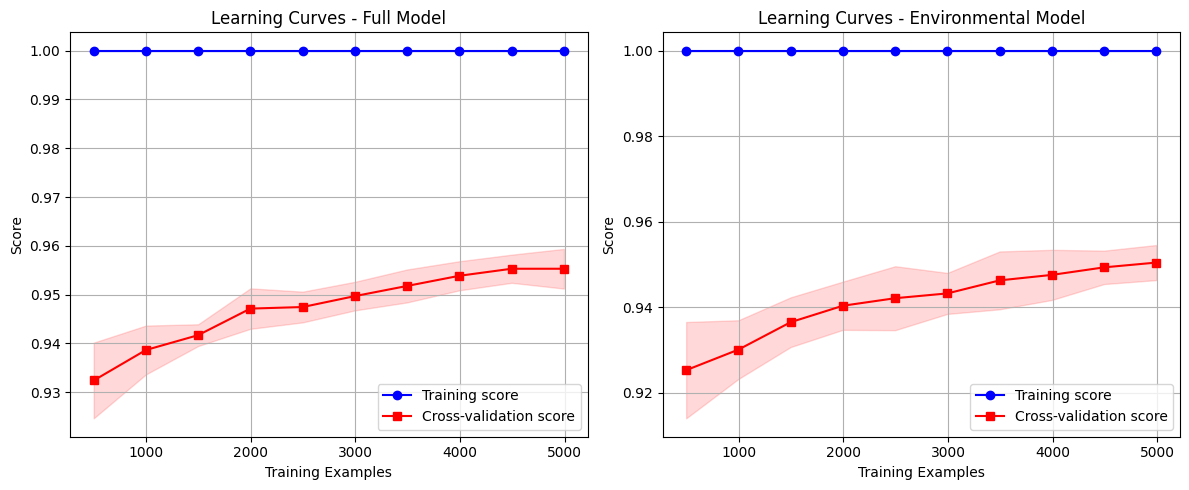


5. SUMMARY
------------------------------
Overfitting occurs when:
- Train accuracy >> Test accuracy
- High variance in cross-validation scores
- Learning curves show training score much higher than CV score

If overfitting is detected, consider:
- Reducing model complexity (fewer trees, max_depth)
- Adding regularization
- Collecting more training data
- Feature selection


In [ ]:
# Overfitting Diagnostics
print("=" * 60)
print("OVERFITTING DIAGNOSTICS")
print("=" * 60)

from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt

# 1. Cross-validation scores
print("1. CROSS-VALIDATION SCORES")
print("-" * 30)

# Full model CV
cv_scores_full = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print(f"Full Model CV Scores: {cv_scores_full}")
print(f"Full Model CV Mean: {cv_scores_full.mean():.4f} (+/- {cv_scores_full.std() * 2:.4f})")

# Environmental model CV
cv_scores_env = cross_val_score(rf_env, X_env, y_env, cv=5, scoring='accuracy')
print(f"Environmental Model CV Scores: {cv_scores_env}")
print(f"Environmental Model CV Mean: {cv_scores_env.mean():.4f} (+/- {cv_scores_env.std() * 2:.4f})")

# 2. Train vs Test Performance
print("\n2. TRAIN VS TEST PERFORMANCE")
print("-" * 30)

# Full model
y_train_pred = rf.predict(X_train)
train_acc_full = accuracy_score(y_train, y_train_pred)
test_acc_full = accuracy_score(y_test, y_pred)
print(f"Full Model - Train Accuracy: {train_acc_full:.4f}")
print(f"Full Model - Test Accuracy: {test_acc_full:.4f}")
print(f"Full Model - Difference (Train-Test): {train_acc_full - test_acc_full:.4f}")

# Environmental model
y_train_pred_env = rf_env.predict(X_train_env)
train_acc_env = accuracy_score(y_train_env, y_train_pred_env)
test_acc_env = accuracy_score(y_test_env, y_pred_env)
print(f"Environmental Model - Train Accuracy: {train_acc_env:.4f}")
print(f"Environmental Model - Test Accuracy: {test_acc_env:.4f}")
print(f"Environmental Model - Difference (Train-Test): {train_acc_env - test_acc_env:.4f}")

# 3. Learning Curves
print("\n3. LEARNING CURVES")
print("-" * 30)

# Calculate learning curves for full model
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

print("Learning curve data calculated. Plot will be shown below.")

# 4. Overfitting Assessment
print("\n4. OVERFITTING ASSESSMENT")
print("-" * 30)

# Define thresholds
overfitting_threshold = 0.05  # 5% difference between train and test
cv_consistency_threshold = 0.1  # 10% standard deviation in CV

# Full model assessment
train_test_diff_full = train_acc_full - test_acc_full
cv_std_full = cv_scores_full.std()

print("Full Model:")
if train_test_diff_full > overfitting_threshold:
    print(f"  Potential overfitting: Train-Test difference = {train_test_diff_full:.4f}")
else:
    print(f"  No significant overfitting: Train-Test difference = {train_test_diff_full:.4f}")

if cv_std_full > cv_consistency_threshold:
    print(f"  High CV variance: CV std = {cv_std_full:.4f}")
else:
    print(f"  Good CV consistency: CV std = {cv_std_full:.4f}")

# Environmental model assessment
train_test_diff_env = train_acc_env - test_acc_env
cv_std_env = cv_scores_env.std()

print("\nEnvironmental Model:")
if train_test_diff_env > overfitting_threshold:
    print(f"  Potential overfitting: Train-Test difference = {train_test_diff_env:.4f}")
else:
    print(f"  No significant overfitting: Train-Test difference = {train_test_diff_env:.4f}")

if cv_std_env > cv_consistency_threshold:
    print(f"  High CV variance: CV std = {cv_std_env:.4f}")
else:
    print(f"  Good CV consistency: CV std = {cv_std_env:.4f}")

# 5. Plot Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red', marker='s')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='red')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves - Full Model')
plt.legend(loc='best')
plt.grid(True)

# Learning curves for environmental model
train_sizes_env, train_scores_env, test_scores_env = learning_curve(
    rf_env, X_env, y_env, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean_env = np.mean(train_scores_env, axis=1)
train_std_env = np.std(train_scores_env, axis=1)
test_mean_env = np.mean(test_scores_env, axis=1)
test_std_env = np.std(test_scores_env, axis=1)

plt.subplot(1, 2, 2)
plt.plot(train_sizes_env, train_mean_env, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes_env, train_mean_env - train_std_env, train_mean_env + train_std_env, alpha=0.15, color='blue')
plt.plot(train_sizes_env, test_mean_env, label='Cross-validation score', color='red', marker='s')
plt.fill_between(train_sizes_env, test_mean_env - test_std_env, test_mean_env + test_std_env, alpha=0.15, color='red')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves - Environmental Model')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

# 6. Summary
print("\n5. SUMMARY")
print("-" * 30)
print("Overfitting occurs when:")
print("- Train accuracy >> Test accuracy")
print("- High variance in cross-validation scores")
print("- Learning curves show training score much higher than CV score")
print("\nIf overfitting is detected, consider:")
print("- Reducing model complexity (fewer trees, max_depth)")
print("- Adding regularization")
print("- Collecting more training data")
print("- Feature selection")

## Testing Other Models

In [16]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

# Prepare features and target
X = HB_1.drop('occurrence', axis=1)
y = HB_1['occurrence']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TPOT
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42, n_jobs=-1)

# Fit TPOT (this may take a while depending on your machine)
tpot.fit(X_train, y_train)

# Evaluate
print("TPOT Test Accuracy:", tpot.score(X_test, y_test))

# Export the best pipeline as Python code
tpot.export('best_pipeline.py')

c:\Users\SABIO\anaconda3\envs\Capstone-Microsoft\lib\site-packages\stopit\__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
c:\Users\SABIO\anaconda3\envs\Capstone-Microsoft\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


c:\Users\SABIO\anaconda3\envs\Capstone-Microsoft\lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
c:\Users\SABIO\anaconda3\envs\Capstone-Microsoft\lib\site-packages\sklearn\base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                             
Generation 1 - Current best internal CV score: 0.95673027737156
                                                                             
Generation 2 - Current best internal CV score: 0.95673027737156
                                                                             
Generation 3 - Current best internal CV score: 0.95673027737156
                                                                             
Generation 4 - Current best internal CV score: 0.95673027737156
                                                                              
Generation 5 - Current best internal CV score: 0.95673027737156
                                                                              
Best pipeline: BernoulliNB(XGBClassifier(input_matrix, learning_rate=0.5, max_depth=3, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0), alpha=10.0, fit_prior=False)
TPOT Test Accurac

## Deep Learning 

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Prepare data
X = HB_1.drop('occurrence', axis=1).values
y = HB_1['occurrence'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for neural nets!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Test Accuracy: {accuracy:.4f}")

# Optional: Classification report
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Epoch 1/30


c:\Users\SABIO\anaconda3\envs\Capstone-Microsoft\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7082 - loss: 0.5354 - val_accuracy: 0.9139 - val_loss: 0.2131
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9230 - loss: 0.2014 - val_accuracy: 0.9229 - val_loss: 0.1947
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9339 - loss: 0.1896 - val_accuracy: 0.9299 - val_loss: 0.1908
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9368 - loss: 0.1785 - val_accuracy: 0.9179 - val_loss: 0.1924
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9445 - loss: 0.1624 - val_accuracy: 0.9219 - val_loss: 0.1959
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9413 - loss: 0.1596 - val_accuracy: 0.9269 - val_loss: 0.1811
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9452 - loss: 0.1545 - val_accuracy: 0.9269 - val_loss: 0.1810
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.1609 - val_accuracy: 0.9299 - val_

## Interpreting

In [ ]:
HB_1 = pd.read_csv('../data/enriched/HB_PSEUDO_clean_elevation_soil.csv')
HB_1.head()

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

HB_1 = pd.read_csv('../data/enriched/HB_PSEUDO_clean_elevation_soil.csv')
HB_1 = HB_1.drop(columns=['gbifID', 'gridmet_lat', 'gridmet_lon', 'gridmet_date', 'decimalLatitude', 'decimalLongitude'])
HB_1.dropna(inplace=True)

# Convert datetime to numeric by extracting components with error handling
def safe_datetime_parse(datetime_series):
    """Safely parse datetime series with mixed formats"""
    parsed_dates = []
    
    for date_str in datetime_series:
        try:
            # Try parsing as full datetime first
            parsed = pd.to_datetime(date_str)
            parsed_dates.append(parsed)
        except:
            try:
                # If that fails, try parsing as date only
                parsed = pd.to_datetime(date_str, format='%Y-%m-%d')
                parsed_dates.append(parsed)
            except:
                # If all else fails, use NaT (Not a Time)
                parsed_dates.append(pd.NaT)
    
    return pd.Series(parsed_dates, index=datetime_series.index)

# Parse the datetime column safely
HB_1['parsed_datetime'] = safe_datetime_parse(HB_1['datetime'])

# Extract datetime components (excluding year)
HB_1['month'] = HB_1['parsed_datetime'].dt.month 
HB_1['day'] = HB_1['parsed_datetime'].dt.day

# Drop datetime columns
HB_1 = HB_1.drop(['datetime', 'parsed_datetime'], axis=1)

def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the function to create a new 'season' column
HB_1['season'] = HB_1['month'].apply(month_to_season)

# If you want to encode it as numbers (optional)
season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
HB_1['season_num'] = HB_1['season'].map(season_map)
HB_1.drop(columns=['season', 'month', 'day'], inplace=True)

# Check for any remaining NaN values and drop them
print(f"Shape before dropping NaN: {HB_1.shape}")
HB_1.dropna(inplace=True)
print(f"Shape after dropping NaN: {HB_1.shape}")

# Separate features and target
X = HB_1.drop('occurrence', axis=1)
y = HB_1['occurrence']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Print results
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Perform 5-fold cross validation
cv_scores = cross_val_score(rf, X, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score: {:.3f} (+/- {:.3f})".format(cv_scores.mean(), cv_scores.std() * 2))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))
print(HB_1.columns)

Shape before dropping NaN: (6240, 12)
Shape after dropping NaN: (6240, 12)
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       921
           1       0.90      0.92      0.91       327

    accuracy                           0.95      1248
   macro avg       0.94      0.94      0.94      1248
weighted avg       0.95      0.95      0.95      1248


Confusion Matrix:
[[887  34]
 [ 26 301]]

Cross-validation scores: [0.95512821 0.94310897 0.94951923 0.94551282 0.94551282]
Average CV score: 0.948 (+/- 0.008)

Top 10 Most Important Features:
                                      feature  importance
9                                     soil_ph    0.283040
8                                   elevation    0.191873
6   surface_downwelling_shortwave_flux_in_air    0.117914
2                           specific_humidity    0.114943
10                                 season_num    0.075361
5                po

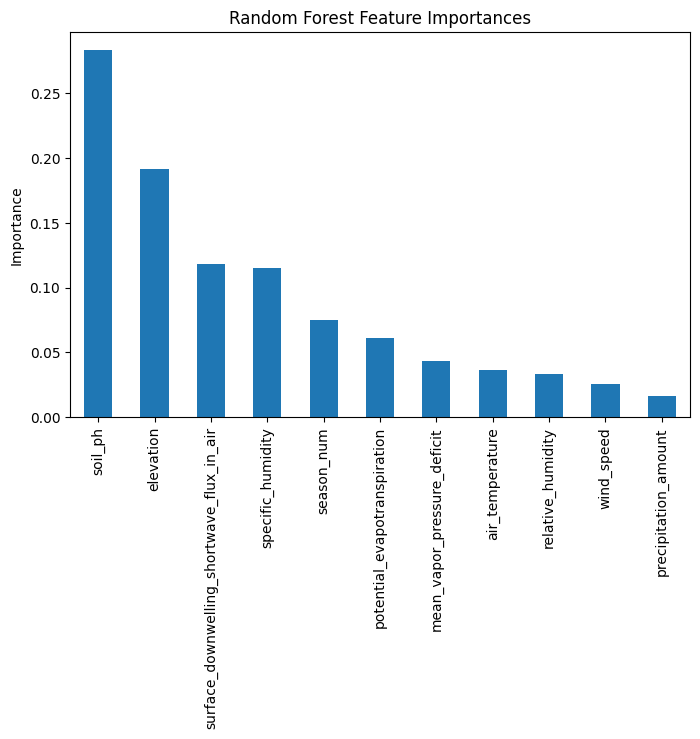

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# For Random Forest
importances = rf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_imp.head(15).plot(kind='bar')
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance')
plt.show()

## Save The Model

In [3]:
import joblib

# Save the trained model
joblib.dump(rf, '../models/random_forest_improved.joblib')

['../models/random_forest_improved.joblib']

In [5]:
import pandas as pd
import joblib

# Load your dataset
HB = pd.read_csv('../data/enriched/HB.csv')

# 1. Filter for Idaho bounding box
idaho_df = HB[
    (HB['decimalLatitude'] >= 41.99) & (HB['decimalLatitude'] <= 49.00) &
    (HB['decimalLongitude'] >= -117.24) & (HB['decimalLongitude'] <= -111.04)
].copy()

# 2. Drop unnecessary columns if present (but KEEP lat/lon for mapping)
idaho_df = idaho_df.drop(columns=['gbifID'], errors='ignore')

# 3. Prepare features for prediction (drop only for X, not for idaho_df)
features = [col for col in idaho_df.columns if col not in ['occurrence', 'decimalLatitude', 'decimalLongitude']]
X_idaho = idaho_df[features]

# 4. Load model and predict
rf = joblib.load('../models/random_forest_1.joblib')
idaho_df['predicted_prob'] = rf.predict_proba(X_idaho)[:, 1]
idaho_df['predicted_class'] = rf.predict(X_idaho)

# 5. (Optional) Show a preview
print(idaho_df[['decimalLatitude', 'decimalLongitude', 'predicted_prob', 'predicted_class']].head())

    decimalLatitude  decimalLongitude  predicted_prob  predicted_class
2         44.409400       -116.078983            0.99                1
6         48.798762       -116.562706            1.00                1
9         47.654857       -116.716292            0.98                1
15        44.551976       -112.655788            0.44                0
20        43.302107       -114.914986            0.06                0


In [6]:
import pandas as pd
import joblib

# Load your dataset
HB = pd.read_csv('../data/test/idaho_gridmet_elevation_soil.csv')

# Convert gridmet_date to datetime and extract components
HB['gridmet_date'] = pd.to_datetime(HB['gridmet_date'])
HB['year'] = HB['gridmet_date'].dt.year
HB['month'] = HB['gridmet_date'].dt.month
HB['day'] = HB['gridmet_date'].dt.day

# Create season_num column (1=Winter, 2=Spring, 3=Summer, 4=Fall)
HB['season_num'] = pd.cut(HB['month'], 
                         bins=[0,3,6,9,12], 
                         labels=[1,2,3,4],
                         include_lowest=True)

# 1. Filter for Idaho bounding box
idaho_df = HB[
    (HB['decimalLatitude'] >= 41.99) & (HB['decimalLatitude'] <= 49.00) &
    (HB['decimalLongitude'] >= -117.24) & (HB['decimalLongitude'] <= -111.04)
].copy()

# 2. Drop unnecessary columns if present (but KEEP lat/lon for mapping)
idaho_df = idaho_df.drop(columns=['gbifID', 'gridmet_date'], errors='ignore')

# 3. Prepare features for prediction (drop only for X, not for idaho_df)
features = [col for col in idaho_df.columns if col not in ['occurrence', 'decimalLatitude', 'decimalLongitude']]
X_idaho = idaho_df[features]

# 4. Load model and predict
rf = joblib.load('../models/random_forest_1.joblib')
idaho_df['predicted_prob'] = rf.predict_proba(X_idaho)[:, 1]
idaho_df['predicted_class'] = rf.predict(X_idaho)

# 5. Print summary statistics to debug
print("Shape of prediction dataset:", idaho_df.shape)
print("\nValue counts of predicted classes:")
print(idaho_df['predicted_class'].value_counts())
print("\nSummary of prediction probabilities:")
print(idaho_df['predicted_prob'].describe())

# 6. Check if features match training data
print("\nFeatures used for prediction:")
print(features)
print("\nFirst few rows of prediction data:")
print(X_idaho.head())

Shape of prediction dataset: (17360, 18)

Value counts of predicted classes:
predicted_class
0    17360
Name: count, dtype: int64

Summary of prediction probabilities:
count    17360.000000
mean         0.078297
std          0.053673
min          0.010000
25%          0.040000
50%          0.050000
75%          0.100000
max          0.400000
Name: predicted_prob, dtype: float64

Features used for prediction:
['air_temperature', 'precipitation_amount', 'specific_humidity', 'relative_humidity', 'mean_vapor_pressure_deficit', 'potential_evapotranspiration', 'surface_downwelling_shortwave_flux_in_air', 'wind_speed', 'elevation', 'soil_ph', 'year', 'month', 'day', 'season_num']

First few rows of prediction data:
     air_temperature  precipitation_amount  specific_humidity  \
124            263.5                   0.0            0.00340   
125            263.9                   0.0            0.00342   
126            264.2                   0.0            0.00343   
127            264.2  

In [ ]:
import folium

# Filter to only predicted occurrences
predicted_df = idaho_df[idaho_df['predicted_class'] == 1]

# Center the map on Idaho
center_lat, center_lon = 44.0682, -114.7420
m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles='cartodbpositron')

# Add points only for predicted occurrences
for _, row in predicted_df.iterrows():
    folium.CircleMarker(
        location=[row['decimalLatitude'], row['decimalLongitude']],
        radius=4,
        color='green',
        fill=True,
        fill_opacity=0.8,
        popup=f"Pred: {row['predicted_prob']:.2f}"
    ).add_to(m)

# Save the map
m.save('./idaho_huckleberry_occurrences.html')
print("✅ Map saved as idaho_huckleberry_occurrences.html")

✅ Map saved as idaho_huckleberry_occurrences.html


In [8]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import geopandas as gpd
from shapely.geometry import Point

# Create a simple Idaho boundary box since shapefile download failed
idaho_bounds = {
    'minx': -117.243027, 
    'miny': 41.988057,
    'maxx': -111.043564,
    'maxy': 49.001146
}

# Filter points to those within Idaho bounds
idaho_points = idaho_df[
    (idaho_df['decimalLongitude'] >= idaho_bounds['minx']) &
    (idaho_df['decimalLongitude'] <= idaho_bounds['maxx']) &
    (idaho_df['decimalLatitude'] >= idaho_bounds['miny']) &
    (idaho_df['decimalLatitude'] <= idaho_bounds['maxy'])
]

# Create a slider for threshold
threshold_slider = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Threshold:',
    continuous_update=False
)

def plot_map(threshold):
    filtered = idaho_points[idaho_points['predicted_prob'] >= threshold]
    fig = px.scatter_mapbox(
        filtered,
        lat='decimalLatitude', 
        lon='decimalLongitude',
        color='predicted_prob',
        color_continuous_scale='Viridis',
        size_max=8,
        zoom=6,
        center={'lat': 44.0682, 'lon': -114.7420},
        mapbox_style='carto-positron',
        hover_data=['predicted_prob']
    )
    
    # Add Idaho bounding box
    box_coords = [
        [idaho_bounds['minx'], idaho_bounds['miny']],
        [idaho_bounds['minx'], idaho_bounds['maxy']], 
        [idaho_bounds['maxx'], idaho_bounds['maxy']],
        [idaho_bounds['maxx'], idaho_bounds['miny']],
        [idaho_bounds['minx'], idaho_bounds['miny']]
    ]
    
    fig.add_scattermapbox(
        mode='lines',
        lon=[c[0] for c in box_coords],
        lat=[c[1] for c in box_coords],
        line=dict(width=2, color='black'),
        showlegend=False
    )
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

widgets.interact(plot_map, threshold=threshold_slider)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0, step=…

<function __main__.plot_map(threshold)>